# Week 6 homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

## Setup

Let's import the libraries that we are going to use in this homework

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Download the data

The data is found in Kaggle using the following link

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-14 14:55:29--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv.1'

housing.csv.1       100%[===================>]   1.36M  6.69MB/s    in 0.2s    

2022-10-14 14:55:30 (6.69 MB/s) - 'housing.csv.1' saved [1423529/1423529]



Use only the following columns:

In [3]:
columns = [
    'latitude', 
    'longitude', 
    'housing_median_age', 
    'total_rooms', 
    'total_bedrooms', 
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity',
]

In [4]:
data = pd.read_csv('housing.csv')

In [5]:
df = data[columns]

Fill the NAs with 0.

In [6]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

Apply the log transform to median_house_value

In [7]:
df.median_house_value = np.log1p(df.median_house_value)

Do train/validation/test split with 60%/20%/20% distribution.

Use the train_test_split function and set the random_state parameter to 1

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [11]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

Use DictVectorizer to turn the dataframe into matrices

In [12]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [13]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the median_house_value vairable.
- Train a model with max_depht=1.

In [14]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

In [15]:
export_text(dt, feature_names=dv.get_feature_names())

/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'|--- ocean_proximity=INLAND <= 0.50\n|   |--- value: [12.31]\n|--- ocean_proximity=INLAND >  0.50\n|   |--- value: [11.61]\n'

## Question 2

Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

In [16]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

What's the RMSE of this model on validation?

In [17]:
y_pred = rf.predict(X_val)
RMSE = mean_squared_error(y_val, y_pred)
round(np.sqrt(RMSE), 2)

0.25

## Question 3

Now let's experiment with the n_estimators parameter
- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

In [18]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                               random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, RMSE))

In [19]:
columns = ['n_estimators', 'RSME']
df_scores = pd.DataFrame(scores, columns=columns)

After which value of n_estimators does RMSE stop improving?

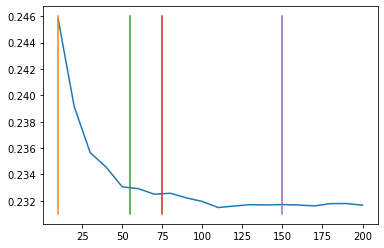

In [20]:
plt.plot(df_scores.n_estimators, df_scores.RSME)
plt.plot((10, 10), (0.231, 0.246))
plt.plot((55, 55), (0.231, 0.246))
plt.plot((75, 75), (0.231, 0.246))
plt.plot((150, 150), (0.231, 0.246))

## Question 4

Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

In [21]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n, RMSE))

In [22]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)

What's the best max_depth?

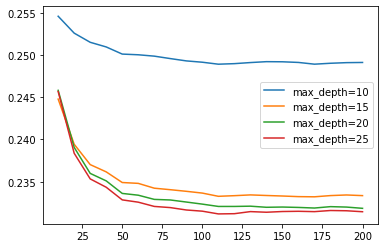

In [23]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.RMSE,
            label='max_depth=%s' %d)
plt.legend()

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in undestanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:
- Train the model with these parameters:
 - n_estimators=10,
 - max_depth=20,
 - random_state=1,
 - n_jobs=-1
- Get the feature importance information from this model

In [24]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

What's the most important feature?

/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

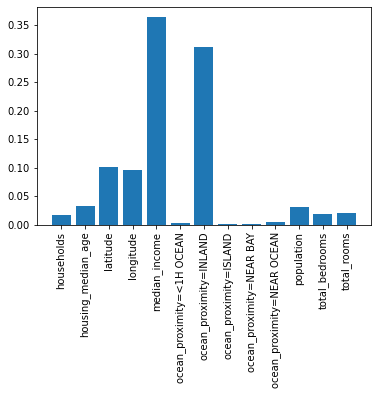

In [25]:
plt.bar(dv.get_feature_names(), rf.feature_importances_)
plt.xticks(rotation=90)

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter.

- Install XGBoost.
- Create DMatrix for train and validation.

In [26]:
features = dv.get_feature_names()
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Create a watchlist.

In [27]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

- Train a model with these parameter for 100 rounds:

In [28]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [29]:
scores = {}

In [30]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                 num_boost_round=100,
                 evals=watchlist)

In [31]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Now change eta to 0.1

In [32]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                 num_boost_round=100,
                 evals=watchlist)

In [33]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Which eta leads to the best RMSE score on the validation dataset?

(0.2, 0.3)

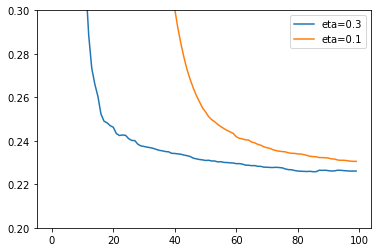

In [34]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)
plt.legend()
plt.ylim(0.2,0.3)